In [20]:
import os
import numpy as np
import shutil
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# Process

Jag börjar med att gå igenom massa Kaggle och Github repos för att få en susning om hur man skall tänka och göra innan jag påbörjar detta i hopp om att slippa göra misstag.

dataset är enormt och jag vill undvika att cold start på koden eller trycka in den, så där det är möljligt försöker jag att använda folderstrukturen som redan finns.

Renskrivning av kod sker regelbundet med LLM. Speciellt efter man fastnar på ett syntaxproblematik som man inte kommer förbi.


# Structure

In [5]:
# Define base path
base_path = r"C:\Coding\Python-Henrik-Pedersen-OPA2023\AI2-Lab2\Data"
train_data_path = os.path.join(base_path, "train")

# Define splits
splits = {
    "experiment_small_data": {
        "train": {"dogs": 800, "cats": 800},
        "val": {"dogs": 200, "cats": 200},
        "test": {"dogs": 250, "cats": 250},
    },
    "experiment_tiny_data": {
        "train": {"dogs": 80, "cats": 80},
        "val": {"dogs": 20, "cats": 20},
        "test": {"dogs": 25, "cats": 25},
    }
}

# Create directory structure
for exp_type, exp_splits in splits.items():
    for split_type, counts in exp_splits.items():
        for animal_type in counts.keys():
            os.makedirs(os.path.join(base_path, exp_type,
                        split_type, animal_type), exist_ok=True)

print("Folder structure created.")

Folder structure created.


In [42]:
import os

#Clear the data first
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

def copy_files(src_folder, dest_folder, num_files):
    files = [os.path.join(src_folder, f)
             for f in os.listdir(src_folder) if f.endswith(".jpg")]
    selected_files = random.sample(files, num_files)

    for file in selected_files:
        shutil.copy(file, dest_folder)


# Define base path
base_path = r"C:\Coding\Python-Henrik-Pedersen-OPA2023\AI2-Lab2\Data"

# Paths to original cat and dog images in the train folder
original_cats_path = os.path.join(base_path, "train", "cats")
original_dogs_path = os.path.join(base_path, "train", "dogs")

# Define splits
splits = {
    "experiment_small_data": {
        "train": {"dogs": 800, "cats": 800},
        "val": {"dogs": 200, "cats": 200},
        "test": {"dogs": 250, "cats": 250},
    },
    "experiment_tiny_data": {
        "train": {"dogs": 80, "cats": 80},
        "val": {"dogs": 20, "cats": 20},
        "test": {"dogs": 25, "cats": 25},
    }
}

# Create directory structure and clear existing files
for exp_type, exp_splits in splits.items():
    for split_type, counts in exp_splits.items():
        for animal_type in counts.keys():
            directory = os.path.join(
                base_path, exp_type, split_type, animal_type)
            clear_directory(directory)

# Copy files to corresponding directories
for exp_type, exp_splits in splits.items():
    for split_type, counts in exp_splits.items():
        copy_files(original_dogs_path, os.path.join(
            base_path, exp_type, split_type, 'dogs'), counts['dogs'])
        copy_files(original_cats_path, os.path.join(
            base_path, exp_type, split_type, 'cats'), counts['cats'])

print("Data split completed.")

Data split completed.


# Basic EDA

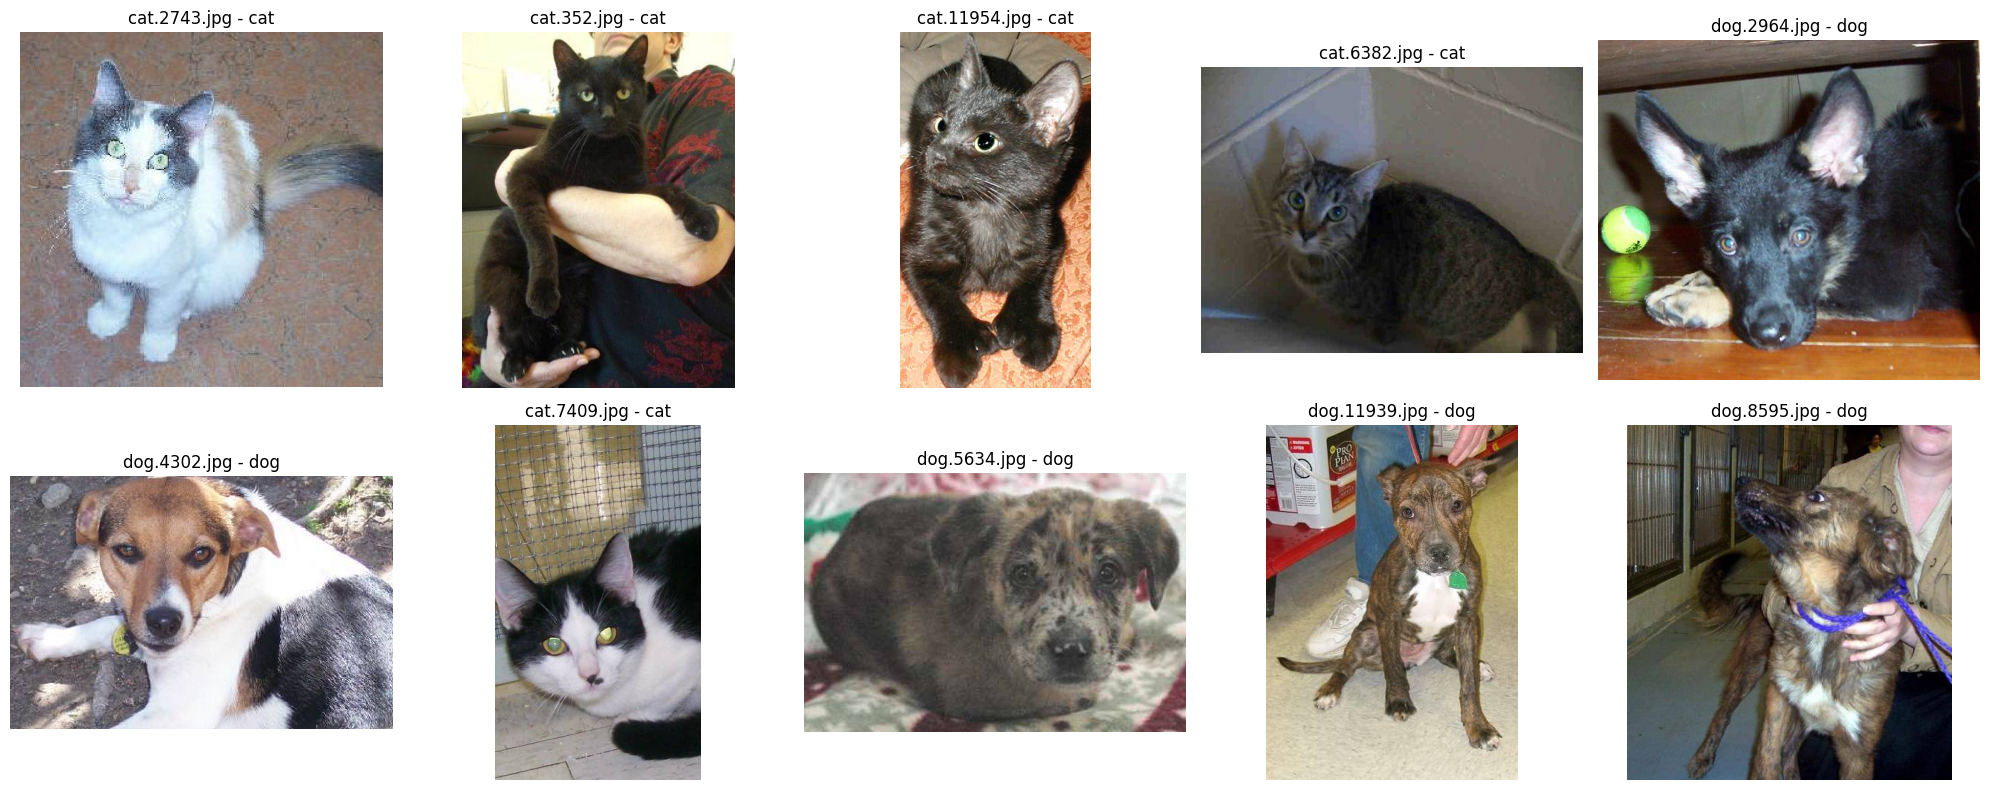

In [43]:
# Path to pics, first the base path followed by cats or dog folder depending on what image we want to take from.
base_path = r"C:\Coding\Python-Henrik-Pedersen-OPA2023\AI2-Lab2\Data\train" 
cats_path = os.path.join(base_path, "cats")
dogs_path = os.path.join(base_path, "dogs")

cat_images = [os.path.join(cats_path, img) for img in os.listdir(cats_path) if img.endswith(".jpg")]
dog_images = [os.path.join(dogs_path, img) for img in os.listdir(dogs_path) if img.endswith(".jpg")]

# Randomly select 5 images from each category
random_cat_images = random.sample(cat_images, 5)
random_dog_images = random.sample(dog_images, 5)

random_pics = random_cat_images + random_dog_images
random.shuffle(random_pics)  

num_images = len(random_pics)

# Subplots to not bloat my Jupiter
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for ax, img_path in zip(axes.flatten(), random_pics):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = "cat" if "cat" in os.path.basename(img_path) else "dog"
    ax.imshow(img_rgb)
    ax.set_title(f"{os.path.basename(img_path)} - {label}")
    ax.axis("off")  # Hide axes

plt.tight_layout()
plt.show()

# Bildbehandling

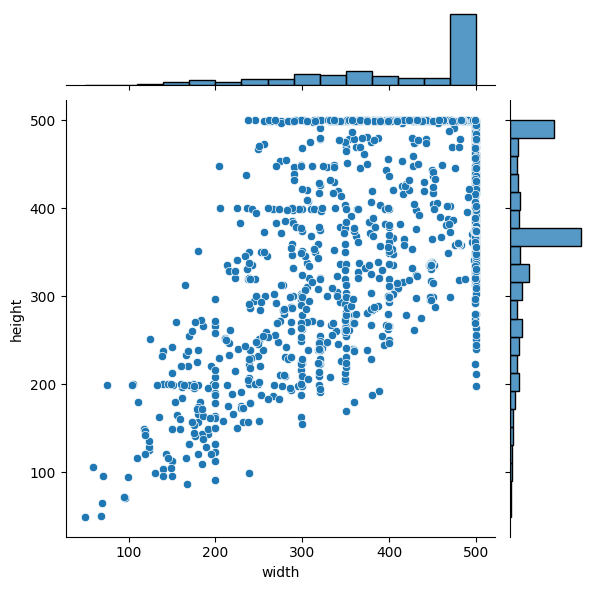

In [44]:
train_dir = r"C:\Coding\Python-Henrik-Pedersen-OPA2023\AI2-Lab2\Data\experiment_small_data\train"


def get_image_sizes(directory):
    sizes = []
    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".jpg"):
                img_path = os.path.join(subdir, file)
                with Image.open(img_path) as img:
                    sizes.append(img.size)  # (width, height)
    return sizes

image_sizes = get_image_sizes(train_dir)

widths, heights = zip(*image_sizes)

image_sizes_df = pd.DataFrame({"width": widths, "height": heights})

# Plot using seaborn"s jointplot
sns.jointplot(x="width", y="height", data=image_sizes_df, kind="scatter")
plt.show()

# Resize + Labels

In [45]:
# Define the chosen size
target_size = (150, 150)


def resize_images_to_array(directory, target_size): #Gippity
    images = []
    labels = []
    class_names = os.listdir(directory)
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for file in tqdm(os.listdir(class_dir), desc=f"Processing {class_name} images"):
                if file.endswith(".jpg"):
                    img_path = os.path.join(class_dir, file)
                    with Image.open(img_path) as img:
                        img_resized = img.resize(target_size)
                        img_array = np.array(img_resized)
                        images.append(img_array)
                        labels.append(class_name)
    return np.array(images), np.array(labels)


train_images, train_labels = resize_images_to_array(train_dir, target_size)

print(f"Shape of training images: {train_images.shape}")
print(f"Shape of training labels: {train_labels.shape}")

Processing dogs images: 100%|██████████| 800/800 [00:01<00:00, 556.03it/s]

Shape of training images: (1600, 150, 150, 3)
Shape of training labels: (1600,)


## Train models

Jag känner att det är viktigt att förstå just train_datagen så detta är vad som sker och varför.

### rescale=1.0/255.0 
Parameter som scale pixel värde mellan 0,255 till 0,1.
Detta ska vara bra för att Neurala nätverk gör bättre ifrån sig om input data är mellan -1,1 eller 0, 1.
### rotation_range=20
roterar bilden upp 20 grader så att saker potentiellt kan bättre hamna i fokus, om t.ex en hund inte är i ett god fokus.
### width_shift_range=0.2,  height_shift_range=0.2 
Genom att skifta bilden horisontellt och vertikalt så skall nätverket lättare kunna lära sig att objektet kanske inte alltid befinner sig i fokus.
### shear_range=0.2
vinklar bilden för att potentiellt få en bättre överblick på objektet. Då en bild kan tas från en vinkel medans en annan bild tas från en helt annan vinkel.
### zoom_range=0.2
Zoomar in för att se bättre.
### horizontal_flip=True
Genom att spegelvända bilden så skall objektet fortfarande vara igenkänbart, då objektet förhoppningsviss skall vara klart nog.
### fill_mode="nearest
Om vi förstör bilden något och lämnar tomrum med de olika augmenteringstekniker så ska denna fylla in de tomma områden relativt realistiskt. 




In [65]:
def random_crop_function(img, crop_size=(150, 150)):
    height, width = img.shape[0], img.shape[1]
    dy, dx = crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    img = img[y:(y+dy), x:(x+dx), :]
    return img


def add_gaussian_noise(img, mean=0, sigma=0.1):
    noise = np.random.normal(mean, sigma, img.shape)
    img = img + noise
    img = np.clip(img, 0, 1)
    return img

In [61]:

# Define paths
base_path = r"C:\Coding\Python-Henrik-Pedersen-OPA2023\AI2-Lab2\Data\experiment_small_data"
train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "val")
test_dir = os.path.join(base_path, "test")

# Data augmentationen
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,          #Preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    #Added segments
    brightness_range=[0.8, 1.2],
    channel_shift_range=50.0,
    preprocessing_function=lambda img: add_gaussian_noise(
        random_crop_function(img))
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode="binary"
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode="binary"
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode="binary"
)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [62]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

c:\Coding\Python-Henrik-Pedersen-OPA2023\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [63]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [66]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=15
)

Epoch 1/15


c:\Coding\Python-Henrik-Pedersen-OPA2023\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 427ms/step - accuracy: 0.4842 - loss: 0.6951 - val_accuracy: 0.5026 - val_loss: 0.7243
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4375 - val_loss: 0.7811
Epoch 3/15


C:\Users\Delic\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 440ms/step - accuracy: 0.4603 - loss: 0.6933 - val_accuracy: 0.5026 - val_loss: 0.7249
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4375 - val_loss: 0.7673
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 461ms/step - accuracy: 0.4726 - loss: 0.6934 - val_accuracy: 0.4974 - val_loss: 0.7220
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5625 - val_loss: 0.6638
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 461ms/step - accuracy: 0.4879 - loss: 0.6932 - val_accuracy: 0.5130 - val_loss: 0.7152
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1875 - val_loss: 0.9251
Epoch 9/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - accuracy: 0.4864 - loss: 0.6932 - val_accuracy: 0.4922 - val_loss: 0.7198
Epoch 10/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.0000e+00 - loss: 0.0

In [67]:
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {test_acc}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.5492 - loss: 0.6951
Test accuracy: 0.5


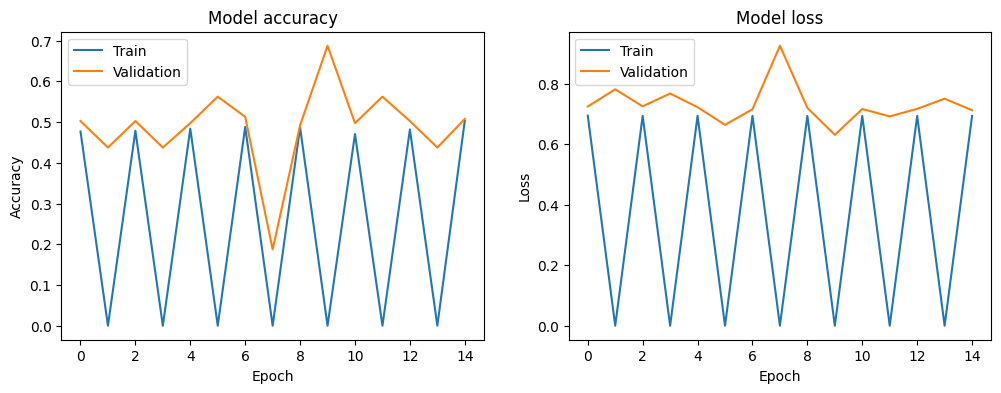

In [68]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper left")

plt.show()